# Installing dependencies

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)

import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')

import warnings
warnings.filterwarnings('ignore')

from time import time

import matplotlib.ticker as tkr
%matplotlib inline

from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
    
import math

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

# Load data and take a look at it

In [4]:
result= pd.read_pickle("/content/drive/MyDrive/Stock+Sentiment_Twitter.pkl")

# original time serie (Y)
y = result.Stock.values 
y = y.astype('float32')
y = np.reshape(y, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
y = scaler.fit_transform(y)



# training and testing settings (size)
percent_of_training = 0.8
train_size = int(len(y) * percent_of_training)
test_size = len(y) - train_size
# 
train_y, test_y = y[0:train_size,:], y[train_size:len(y),:]


def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# Splitting data

In [5]:
look_back = 7


# features of the original time serie (y)
X_train_features_1, y_train = create_dataset(train_y, look_back)
X_test_features_1, y_test = create_dataset(test_y, look_back)




# join the all the features in one
## reshape arrays
X_train_features = np.reshape(X_train_features_1, (X_train_features_1.shape[0], 1, X_train_features_1.shape[1]))
X_test_features  = np.reshape(X_test_features_1, (X_test_features_1.shape[0], 1, X_test_features_1.shape[1]))

# Model

In [6]:
model = Sequential()
model.add(LSTM(200, input_shape=(X_train_features.shape[1], X_train_features.shape[2])))
model.add(Dropout(0.20))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train_features,y_train, epochs=300, batch_size=25, validation_data=(X_test_features, y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=0, shuffle=False)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               166400    
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 166,601
Trainable params: 166,601
Non-trainable params: 0
_________________________________________________________________


In [ ]:
np.any(np.isnan(X_train_features))
np.all(np.isfinite(X_train_features))

True

In [7]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134 entries, 4 to 177
Data columns (total 16 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Time                                          134 non-null    object 
 1   Date                                          134 non-null    object 
 2   News source                                   134 non-null    object 
 3   Title                                         134 non-null    object 
 4   Description                                   134 non-null    object 
 5   index                                         134 non-null    int64  
 6   timestamp                                     134 non-null    float64
 7   uid                                           134 non-null    object 
 8   url                                           134 non-null    object 
 9   url_uid                                       134 non-null    int

# Training

In [8]:
import time
from sklearn.metrics import r2_score
t0 = time.time()

train_predict = model.predict(X_train_features)
test_predict  = model.predict(X_test_features)

#train_predict = scaler.inverse_transform(train_predict)
#Y_train = scaler.inverse_transform(y_train)
#test_predict = scaler.inverse_transform(test_predict)
#Y_test = scaler.inverse_transform(y_test)

t1 = time.time()

print('Training Time: ', t1 - t0)

print('Train Mean Absolute Error:', mean_absolute_error(np.reshape(y_train,(y_train.shape[0],1)), train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(np.reshape(y_train,(y_train.shape[0],1)), train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(np.reshape(y_test,(y_test.shape[0],1)), test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(np.reshape(y_test,(y_test.shape[0],1)), test_predict[:,0])))
print(f'R-square= {r2_score(np.reshape(y_train,(y_train.shape[0],1)), train_predict[:,0])}')

Training Time:  0.5252962112426758
Train Mean Absolute Error: 0.09982558
Train Root Mean Squared Error: 0.13235795
Test Mean Absolute Error: 0.030354753
Test Root Mean Squared Error: 0.038816422
R-square= 0.7732458928439062


# Results

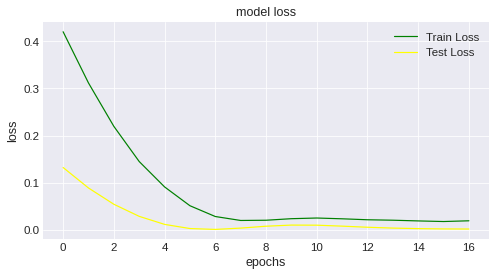

In [9]:
plt.figure(figsize=(8,4))
plt.style.use('seaborn-dark')

plt.plot(history.history['loss'], label='Train Loss',color="green")
plt.plot(history.history['val_loss'], label='Test Loss',color = "yellow")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.grid()

plt.show();

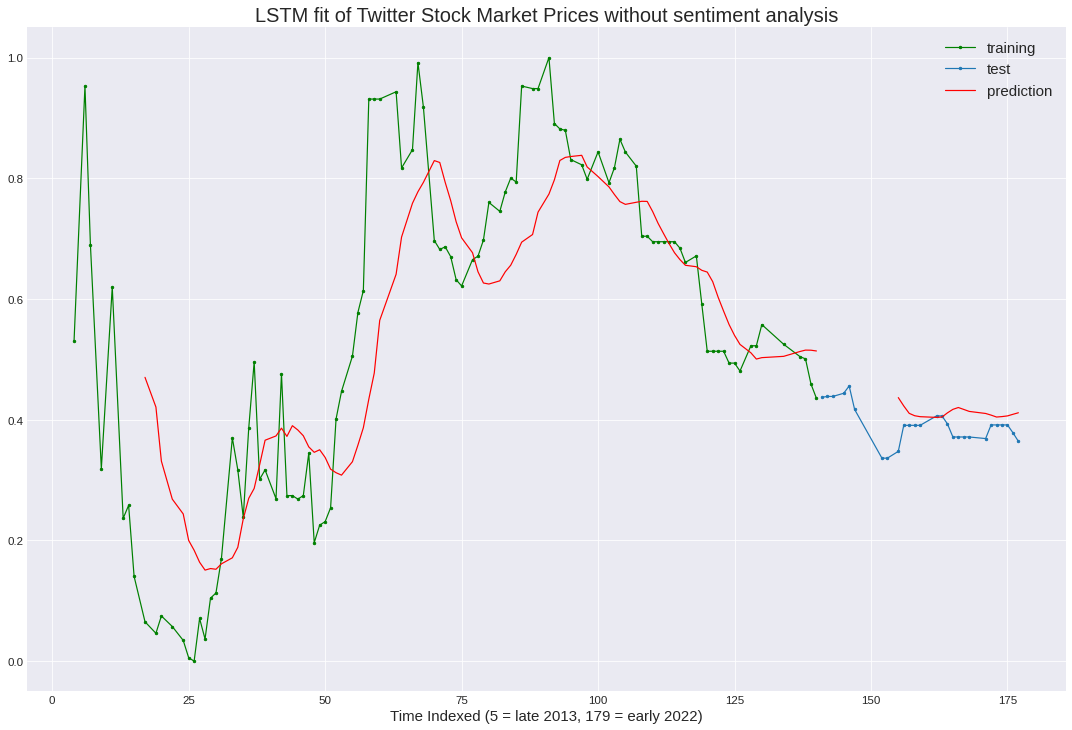

In [10]:
time_y_train = pd.DataFrame(data = train_y, index = result[0:train_size].index,columns= [""])
time_y_test  = pd.DataFrame(data = test_y, index = result[train_size:].index,columns= [""])

time_y_train_prediction = pd.DataFrame(data = train_predict, index = time_y_train[8:].index,columns= [""])
time_y_test_prediction  = pd.DataFrame(data = test_predict, index = time_y_test[8:].index,columns= [""])


plt.style.use('seaborn-dark')
plt.figure(figsize=(15,10))

plt.plot(time_y_train,label = "training",color ="green",marker='.')
plt.plot(time_y_test,label = "test",marker='.')
plt.plot(time_y_train_prediction,color="red",label = "prediction")
plt.plot(time_y_test_prediction,color="red")
plt.title("LSTM fit of Twitter Stock Market Prices without sentiment analysis",size = 20)
plt.tight_layout()
sns.despine(top=True)
plt.ylabel('', size=15)
plt.xlabel('Time Indexed (5 = late 2013, 179 = early 2022)', size=15)
plt.legend(fontsize=15)
plt.grid()

plt.show();